## Script to Fit Mass1 and Mass2 for binaries

#### -- We know dmag in v and i bands from speckle. We know dmag in h/k bands from interferometry. We know total magnitudes in these bands.
#### -- In theory, we know distance from Hipparcos or Gaia (this is weakest point, as they are unresolved binaries!)

#### -- Compare 3 bands to model SEDs to fit for mass
#### -- I am using models compiled by Eric Mamjek: http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt
#### -- From Table 5 of Pecaut & Mamajek (2013); and Table 3 of Pecaut, Mamajek, & Bubar (2012) for A/F/G stars

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import random
from astroquery.simbad import Simbad
from uncertainties import ufloat
from uncertainties.umath import *
import pandas as pd
%matplotlib inline

In [2]:
## Read in values from file of model SEDs for different stellar masses
## Making arrays for fitting later
model_file = open(os.path.expanduser("sptype_colors.txt"))
sptype=[]
mass=[]
mv_model=[]
b_v=[]
g_v=[]
g_rp=[]
u_b=[]
v_r=[]
v_k=[]
h_k=[]
j_h=[]
v_i=[]

for line in model_file.readlines():
    if line.startswith('#'):
        continue
    sptype.append(line.split()[0])
 
    try:
        mass.append(float(line.split()[30]))
    except:
        mass.append(np.nan)
        
    try:
        mv_model.append(float(line.split()[7]))
    except:
        mv_model.append(np.nan)
        
    try:
        b_v.append(float(line.split()[8]))
    except:
        b_v.append(np.nan)
        
    try:
        g_v.append(float(line.split()[10]))
    except:
        g_v.append(np.nan)
        
    try:
        g_rp.append(float(line.split()[12]))
    except:
        g_rp.append(np.nan)
    
    try:
        u_b.append(float(line.split()[15]))
    except:
        u_b.append(np.nan)
        
    try:
        v_r.append(float(line.split()[16]))
    except:
        v_r.append(np.nan)
        
    try:
        v_i.append(float(line.split()[17]))
    except:
        v_i.append(np.nan)
        
    try:
        v_k.append(float(line.split()[18]))
    except:
        v_k.append(np.nan)
        
    try:
        h_k.append(float(line.split()[20]))
    except:
        h_k.append(np.nan)
        
    try:
        j_h.append(float(line.split()[19]))
    except:
        j_h.append(np.nan)
        
sptype=np.array(sptype)
mass=np.array(mass)
mv_model=np.array(mv_model)
b_v=np.array(b_v)
v_i=np.array(v_i)
g_v=np.array(g_v)
g_rp=np.array(g_rp)
u_b=np.array(u_b)
v_r=np.array(v_r)
v_k=np.array(v_k)
h_k=np.array(h_k)
j_h=np.array(j_h)

## Get mags in each band:
b_model = b_v+mv_model
u_model = u_b+b_model
i_model = mv_model-v_i
g_model = g_v+mv_model
rp_model = g_model-g_rp
r_model = mv_model-v_r
k_model = mv_model-v_k
h_model = h_k+k_model
j_model = j_h+h_model

## Now select a binary target to query

In [3]:
target_hd = '6456'
df = pd.read_csv("full_target_list.csv",dtype=object)

## Create directory for saved files, if it doesn't already exist
directory = "binary_orbits/HD_%s/"%target_hd
if not os.path.exists(directory):
    print("Creating directory")
    os.makedirs(directory)

In [4]:
idx = np.where(df['HD']==target_hd)[0][0]

distance_gaia = float(df['Gaia_distance (pc)'][idx])
distance_hip = float(df['HIP_distance (pc)'][idx])
print("distance gaia = ",distance_gaia)
print("distance hip = ",distance_hip)


cdiff_h = float(df['dmag_h'][idx])
cdiff_k = float(df['dmag_k'][idx])
cdiff_i = float(df['dmag_speckle_i'][idx])
cdiff_v = float(df['dmag_speckle_v'][idx])

fratio_h = 10**(cdiff_h/2.5)
fratio_k = 10**(cdiff_k/2.5)
fratio_i = 10**(cdiff_i/2.5)
fratio_v = 10**(cdiff_v/2.5)

print("fratio: k_mag, h_mag, i_mag, v_mag = ", fratio_k,fratio_h,fratio_i,fratio_v)

distance gaia =  93.38
distance hip =  84.32
fratio: k_mag, h_mag, i_mag, v_mag =  nan 1.7060823890031234 1.905460717963247 2.1086281499332893


In [5]:
## choose which distance to use -- not necessarily obvious! We may want to compare both
distance = distance_hip

In [6]:
## This cell only needs to be run once. For adding quantities of interest for Simbad query
Simbad.add_votable_fields('flux(U)')
Simbad.add_votable_fields('flux(B)')
Simbad.add_votable_fields('flux(V)')
Simbad.add_votable_fields('flux(G)')
Simbad.add_votable_fields('flux(R)')
Simbad.add_votable_fields('flux(J)')
Simbad.add_votable_fields('flux(H)')
Simbad.add_votable_fields('flux(K)')
Simbad.add_votable_fields('flux_error(U)')
Simbad.add_votable_fields('flux_error(B)')
Simbad.add_votable_fields('flux_error(V)')
Simbad.add_votable_fields('flux_error(G)')
Simbad.add_votable_fields('flux_error(R)')
Simbad.add_votable_fields('flux_error(J)')
Simbad.add_votable_fields('flux_error(H)')
Simbad.add_votable_fields('flux_error(K)')

In [7]:
## query total magnitudes and errors from Simbad
query = Simbad.query_object('HD %s'%target_hd)

ktot = query['FLUX_K'][0]
utot = query['FLUX_U'][0]
btot = query['FLUX_B'][0]
rtot = query['FLUX_R'][0]
htot = query['FLUX_H'][0]
jtot = query['FLUX_J'][0]
vtot = query['FLUX_V'][0]
gtot = query['FLUX_G'][0]

kerr = query['FLUX_ERROR_K'][0]
uerr = query['FLUX_ERROR_U'][0]
berr = query['FLUX_ERROR_B'][0]
rerr = query['FLUX_ERROR_R'][0]
herr = query['FLUX_ERROR_H'][0]
jerr = query['FLUX_ERROR_J'][0]
verr = query['FLUX_ERROR_V'][0]
gerr = query['FLUX_ERROR_G'][0]

ktot = ufloat(ktot,kerr)
utot = ufloat(utot,uerr)
btot = ufloat(btot,berr)
rtot = ufloat(rtot,rerr)
htot = ufloat(htot,herr)
jtot = ufloat(jtot,jerr)
vtot = ufloat(vtot,verr)
gtot = ufloat(gtot,gerr)

print("K,H,J,R,G,V,B,U = ", ktot,htot,jtot,rtot,gtot,vtot,btot,utot)

K,H,J,R,G,V,B,U =  5.265+/-0.027 5.301+/-0.021 5.24+/-0.05 nan+/-nan 5.268+/-0.006 5.273+/-0.009 5.263+/-0.014 5.260000228881836+/-nan


/Users/tgardner/opt/anaconda3/lib/python3.9/site-packages/uncertainties/core.py:2801: UserWarning: Warning: converting a masked element to nan.
  self._std_dev = CallableStdDev(std_dev)
/Users/tgardner/opt/anaconda3/lib/python3.9/site-packages/uncertainties/core.py:2766: UserWarning: Warning: converting a masked element to nan.
  value = float(value)


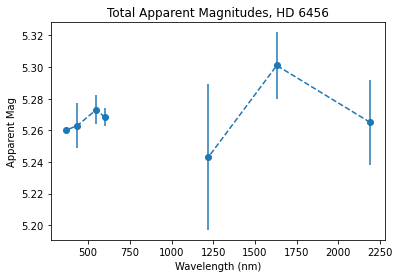

In [8]:
x = np.array([2190,1630,1220,634.9,600,547.7,435.3,365.6]) ## central wavelengths of Simbad magnitudes chosen above
y = np.array([ktot.nominal_value,htot.nominal_value,jtot.nominal_value,
              rtot.nominal_value,gtot.nominal_value,vtot.nominal_value,
              btot.nominal_value,utot.nominal_value])
yerr = np.array([ktot.std_dev,htot.std_dev,jtot.std_dev,rtot.std_dev,
                 gtot.std_dev,vtot.std_dev,btot.std_dev,utot.std_dev])

plt.title("Total Apparent Magnitudes, HD %s"%target_hd)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Apparent Mag")
plt.errorbar(x,y,yerr,fmt='o--')
plt.savefig("%s/HD_%s_total_mags.pdf"%(directory,target_hd))
plt.show()

In [9]:
data_wave = np.array([547.7,879.9,1630,2190]) ## wavelengths of our speckle + interferometry data

k1 = -2.5*log10(10**(-ktot/2.5)/(1+10**(-cdiff_k/2.5)))
k2 = cdiff_k + k1

h1 = -2.5*log10(10**(-htot/2.5)/(1+10**(-cdiff_h/2.5)))
h2 = cdiff_h + h1

i1 = -2.5*log10(10**(-gtot/2.5)/(1+10**(-cdiff_i/2.5)))
i2 = cdiff_i + i1

v1 = -2.5*log10(10**(-vtot/2.5)/(1+10**(-cdiff_v/2.5)))
v2 = cdiff_v + v1

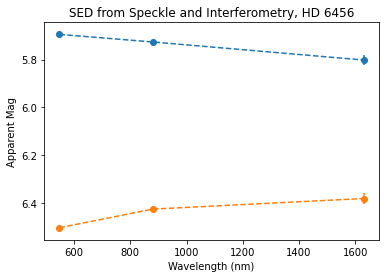

In [10]:
p1 = np.array([v1.nominal_value,i1.nominal_value,h1.nominal_value,k1.nominal_value])
p1err = np.array([v1.std_dev,i1.std_dev,h1.std_dev,k1.std_dev])
p2 = np.array([v2.nominal_value,i2.nominal_value,h2.nominal_value,k2.nominal_value])
p2err = np.array([v2.std_dev,i2.std_dev,h2.std_dev,k2.std_dev])

plt.title("SED from Speckle and Interferometry, HD %s"%target_hd)
plt.errorbar(data_wave,p1,p1err,fmt='o--')
plt.errorbar(data_wave,p2,p2err,fmt='o--')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Apparent Mag')
plt.gca().invert_yaxis()
plt.savefig("%s/HD_%s_split_mags.pdf"%(directory,target_hd))
plt.show()

## Now we will perform a fit to measure individual masses

2.05
1.88


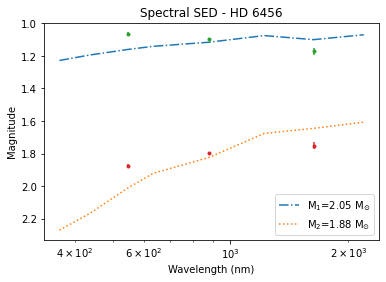

In [16]:
## NOTE: This cell needs to be adapted to a fitting routine

## Choose masses to plot:
m1 = 2.1
m2 = 1.9

## Absolute magnitudes depend on the distance chosen:
abs_v1 = v1 - 2.5*log10((distance/10)**2)
abs_i1 = i1 - 2.5*log10((distance/10)**2)
abs_h1 = h1 - 2.5*log10((distance/10)**2)
abs_k1 = k1 - 2.5*log10((distance/10)**2)
abs_v2 = v2 - 2.5*log10((distance/10)**2)
abs_i2 = i2 - 2.5*log10((distance/10)**2)
abs_h2 = h2 - 2.5*log10((distance/10)**2)
abs_k2 = k2 - 2.5*log10((distance/10)**2)

## Data magnitudes:
p1 = np.array([abs_v1.nominal_value,abs_i1.nominal_value,abs_h1.nominal_value,abs_k1.nominal_value])
p1err = np.array([abs_v1.std_dev,abs_i1.std_dev,abs_h1.std_dev,abs_k1.std_dev])
p2 = np.array([abs_v2.nominal_value,abs_i2.nominal_value,abs_h2.nominal_value,abs_k2.nominal_value])
p2err = np.array([abs_v2.std_dev,abs_i2.std_dev,abs_h2.std_dev,abs_k2.std_dev])

## Choose the closest mass in the model to the ones specified above:
idx1 = np.nanargmin(abs(mass-m1))
print(mass[idx1])
idx2 = np.nanargmin(abs(mass-m2))
print(mass[idx2])

## Model magnitudes:
y1 = np.array([u_model[idx1],b_model[idx1],mv_model[idx1],r_model[idx1],i_model[idx1],j_model[idx1],h_model[idx1],k_model[idx1]])
y2 = np.array([u_model[idx2],b_model[idx2],mv_model[idx2],r_model[idx2],i_model[idx2],j_model[idx2],h_model[idx2],k_model[idx2]])
x = [365.6,435.3,547.7,634.9,879.7,1220,1630,2190]

plt.plot(x,y1,linestyle='dashdot',label='M$_1$=%s M$_{\odot}$'%mass[idx1])
plt.plot(x,y2,linestyle='dotted',label='M$_2$=%s M$_{\odot}$'%mass[idx2])
plt.errorbar(data_wave,p1,p1err,fmt='.')
plt.errorbar(data_wave,p2,p2err,fmt='.')
plt.title('Spectral SED - HD %s'%target_hd)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude')
plt.xscale('log')
plt.gca().invert_yaxis()
plt.legend()
plt.savefig("%s/HD_%s_mass_spectral_fit.pdf"%(directory,target_hd))
plt.show()